# Loss-functions in Denoising Neural Networks
In this Jupyter notebook we will demonstrate results for our paper for the DTU course 02456 Deep Learning project.

## Loss-functions
We have chosen to test the four following loss-functions:

1.   Mean Absolute Error (MAE)
\begin{align*}
   MAE = \frac{1}{n} \sum_{i=1}^{n} |s_i - \hat{s}_i|
\end{align*}
2.   Mean Squared Error (MSE)
\begin{align*}
    MSE = \frac{1}{n} \sum_{i=1}^{n} (s_i - \hat{s}_i)^2
\end{align*}
3.   Signal-to-Noise Ratio (SNR)
\begin{align*}
    SNR &= 10 \log_{10}\left(\frac{\|s\|^2}{\|s-\hat{s}\|^2}\right)
\end{align*}
4.   Scale-Invariant Signal-to-Noise Ratio (SI-SNR)




## Initializing the model
First we load up model with pretrained weights.
Here we are using a subset of the audio-files available for demonstration.

In [8]:
# Install a packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install descript-audio-codec
!pip3 install torch torchaudio torchvision torchtext torchdata
!{sys.executable} -m pip install torchmetrics
!{sys.executable} -m pip install torchaudio

  Using cached descript_audio_codec-1.0.0-py3-none-any.whl (26 kB)
  Using cached argbind-0.3.7.tar.gz (16 kB)
  Preparing metadata (setup.py) ... done
  Using cached descript_audiotools-0.7.2-py2.py3-none-any.whl (106 kB)
  Using cached einops-0.7.0-py3-none-any.whl (44 kB)
  Using cached docstring_parser-0.15-py3-none-any.whl (36 kB)
  Using cached pyloudnorm-0.1.1-py3-none-any.whl (9.6 kB)
  Using cached julius-0.2.7.tar.gz (59 kB)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [9]:
import torchaudio.functional as F
from IPython.display import Audio
from torchaudio.utils import download_asset
import torch

def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()




### Building the dataloader
Next step is to define our dataloader and use it to load the audio-files as datasets.

In [10]:
import torch
import os
import torchaudio
from pathlib import Path
import torchaudio.functional as F
import torchaudio.transforms as T
from audiotools import AudioSignal
# from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import os
import random
import soundfile
import numpy as np

class NoiseSpeechDataset(Dataset):
    def __init__(self, directory, target_sample_rate, len_speech, is_speech, dataset_type):
        self.target_sample_rate = target_sample_rate
        self.directory = directory
        self.len_speech = len_speech
        self.files_ns = os.listdir(directory)
        self.is_speech = is_speech
        self.type = dataset_type

        #split the dataset into train, val and test
        self.initialize_dataset_state()

    def initialize_dataset_state(self):
        if self.type == "noise":
            return

        #By using a seed we guarantee the shuffle is always the same for training, validation and test sets
        np.random.seed(6979)
        np.random.shuffle(self.files_ns)

        # Sizes for each part of the array
        self.size_train_data = int(len(self.files_ns)*0.70 )  # 70% of the total size
        self.size_val_data = int(len(self.files_ns)*0.15 )  # 15% of the total size
        self.size_test_data = int(len(self.files_ns)*0.15)  # 15% of the total size


        #use a seed to shuffle - making each split identitical each time the dataset is initialized
        split_train = int(self.size_train_data)
        split_val = int(self.size_val_data) + split_train
        split_test = int(self.size_test_data) + split_val + split_train

        #Splits up the entire clean sound directory into three parts
        self.indicies_train = self.files_ns[0:split_train]
        self.indicies_val = self.files_ns[split_train:split_val]
        self.indicies_test = self.files_ns[split_val:split_test]

    def __len__(self):
        if self.type == "noise":
            return len(self.files_ns)
        return self.size_train_data + self.size_val_data + self.size_test_data
        # return len(self.files_ns)


    def __getitem__(self, idx):
        file_path = None

        if self.type == "train":
            item = random.choice(self.indicies_train)
            file_path = os.path.join(self.directory, item)
        elif self.type == "val":
            item = random.choice(self.indicies_val)
            file_path = os.path.join(self.directory, item)
        elif self.type == "test":
            item = random.choice(self.indicies_test)
            file_path = os.path.join(self.directory, item)
        else: #our local noise directory
            file_path = os.path.join(self.directory, self.files_ns[idx])


        waveform, sample_rate = torchaudio.load(file_path,backend="soundfile")
        # print("filepath:", file_path)
        # print(waveform.shape)
        seconds = waveform.shape[1]/sample_rate
        # f'seconds:{seconds}'
        # print(seconds)
        # print("-----")
        if self.is_speech:
            if seconds > 3:
                random_start = random.randrange(0, waveform.shape[1]-sample_rate*self.len_speech)
                #print("Start:", random_start, " End: ",random_start+sample_rate*self.len_speech)
                waveform = waveform[:,random_start:random_start+sample_rate*self.len_speech]
            else:
                # print("inside speech else")
                #padding here
                pad_len = len_speech*sample_rate - waveform.shape[1]
                # waveform = F.pad_waveform(waveform, 0, pad_len, "constant")
                num_samples_to_pad = max(0, pad_len)
                z = torch.zeros(1,num_samples_to_pad) #waveform.shape[0]
                waveform = torch.cat((waveform,z),1)
        else: #noise directory
            if seconds > 3:
                random_start = random.randrange(0, waveform.shape[1]-sample_rate*len_speech)
                waveform = waveform[:,random_start:random_start+sample_rate*self.len_speech]
            else:
                while(waveform.shape[1]<sample_rate*len_speech):
                    pad_len = len_speech*sample_rate - waveform.shape[1]
                    num_samples_to_pad = min(waveform.shape[1], pad_len)
                    # print("noise")
                    waveform = torch.cat((waveform,waveform[0:num_samples_to_pad]))

        # print("<---->")
        #print(waveform.shape[1]/sample_rate)

        #Resample here
        transform = T.Resample(sample_rate, self.target_sample_rate)
        waveform = transform(waveform)

        return waveform, self.target_sample_rate

In [11]:
from google.colab import drive
drive.mount('/content/drive')


# # Specify the directory containing your data
# # dataset_directory = 'noisespeech_pairs'
dataset_noise_path = "/content/drive/MyDrive/Audio/Noise"
dataset_speech_path = "/content/drive/MyDrive/Audio/Speech"
dataset_speech_test_path = "Audio/Speech_test"


# Create the dataset and data loader
target_sample_rate = 44100
len_speech = 3


#Make sure to make a new noise loader, once the old one is exhausted
def noise_loader(dataset):
    while True:
        loader = DataLoader(dataset, batch_size=g_bs, shuffle=True)
        for data in loader:
            yield data



#Dataset
#dataset_speech_train = NoiseSpeechDataset(dataset_speech_path, target_sample_rate, len_speech, is_speech=True, dataset_type="train")
dataset_speech_val = NoiseSpeechDataset(dataset_speech_path, target_sample_rate, len_speech, is_speech=True, dataset_type="test")
dataset_noise =  NoiseSpeechDataset(dataset_noise_path, target_sample_rate, len_speech, is_speech=False, dataset_type="noise")

#Loaders
g_bs = 1
#data_loader_speech_train = DataLoader(dataset_speech_train, batch_size=g_bs, shuffle=True)
data_loader_speech_val = DataLoader(dataset_speech_val, batch_size=g_bs, shuffle=True)
# data_loader_noise = DataLoader(dataset_noise, batch_size=g_bs, shuffle=True)
data_loader_noise = noise_loader(dataset_noise)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print(len(data_loader_speech_val))
# print(len(data_loader_speech_train))
foo = iter(data_loader_speech_val)
print(next(foo))
print(next(foo))

283
[tensor([[[0.0001, 0.0003, 0.0002,  ..., 0.0000, 0.0000, 0.0000]]]), tensor([44100])]
[tensor([[[0.0016, 0.0016, 0.0017,  ..., 0.0004, 0.0002, 0.0003]]]), tensor([44100])]


Load the model

In [15]:
import dac
import os
import torchaudio.functional as F
import torch
import numpy as np
from audiotools import AudioSignal
from torchmetrics.audio import SignalNoiseRatio
import random

model_path_mae = dac.utils.download(model_type="44khz")
model_mae = dac.DAC.load(model_path_mae)
model_mae.load_state_dict(torch.load("/content/drive/MyDrive/model_weights_mae.pth", map_location=torch.device('cpu') ))
# model_mae.to('cuda')

model_path_mse = dac.utils.download(model_type="44khz")
model_mse = dac.DAC.load(model_path_mse)
model_mse.load_state_dict(torch.load("/content/drive/MyDrive/model_weights_mse.pth", map_location=torch.device('cpu') ))
# model_mse.to('cuda')

model_path_si_snr = dac.utils.download(model_type="44khz")
model_si_snr = dac.DAC.load(model_path_si_snr)
model_si_snr.load_state_dict(torch.load("/content/drive/MyDrive/model_weights_si_snr.pth", map_location=torch.device('cpu') ))
# model_si_snr.to('cuda')

model_path_snr = dac.utils.download(model_type="44khz")
model_snr = dac.DAC.load(model_path_snr)
model_snr.load_state_dict(torch.load("/content/drive/MyDrive/model_weights_snr.pth", map_location=torch.device('cpu') ))
# model_snr.to('cuda')


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

## Audio files before and after the model

In order to make the results less abstract, we have picked out

In [17]:
#Examples of audio before and after noise
from IPython.display import Audio
# import gc
from torchaudio.pipelines import SQUIM_SUBJECTIVE

# squim_subjective_model = SQUIM_SUBJECTIVE.get_model().to('cuda')
squim_subjective_model = SQUIM_SUBJECTIVE.get_model()


with torch.no_grad():
  model_snr.eval()
  model_si_snr.eval()
  model_mse.eval()
  model_mae.eval()

  #Load speech file and nose file
  speech_iter = iter(data_loader_speech_val)
  noise_iter = iter(data_loader_noise)
  speech1, s_sz = next(speech_iter)
  noise1, n_sz = next(noise_iter)

  #Set the noise ratio and add speech, noise together
  snr_dbs = torch.tensor([[2.0]])
  signal = F.add_noise(speech1,noise1, snr=snr_dbs)

  if torch.isnan(signal).any():
      print("NaN values detected in signal.audio_data, SKIPPING")
  else:
    sample_rate = 44100
    signal = AudioSignal(signal, sample_rate=sample_rate)
    # signal.to('cuda')

    # speech1_squim = speech1[0].to('cuda')
    speech1_squim = speech1[0]


    #M1
    x_snr = model_snr.preprocess(signal.audio_data, signal.sample_rate)
    z_snr, codes, latents, _, _ = model_snr.encode(x_snr)
    y_orig_snr = model_snr.decode(z_snr)


    y_resampled_snr = F.resample(y_orig_snr, orig_freq=sample_rate, new_freq=16000)

    # y_squim_snr = y_resampled_snr[0].to('cuda')
    y_squim_snr = y_resampled_snr[0]


    mos_snr = squim_subjective_model(y_squim_snr, speech1_squim)

    #M2
    x_si_snr = model_si_snr.preprocess(signal.audio_data, signal.sample_rate)
    z_si_snr, _, _, _, _ = model_si_snr.encode(x_si_snr)
    y_orig_si_snr = model_si_snr.decode(z_si_snr)

    y_resampled_si_snr = F.resample(y_orig_si_snr, orig_freq=sample_rate, new_freq=16000)
    # y_squim_si_snr = y_resampled_si_snr[0].to('cuda')
    y_squim_si_snr = y_resampled_si_snr[0]


    mos_si_snr = squim_subjective_model(y_squim_si_snr, speech1_squim)

    #M3
    x_mse = model_mse.preprocess(signal.audio_data, signal.sample_rate)
    z_mse, _, _, _, _ = model_mse.encode(x_mse)
    y_orig_mse = model_mse.decode(z_mse)

    y_resampled_mse = F.resample(y_orig_mse, orig_freq=sample_rate, new_freq=16000)
    # y_squim_mse = y_resampled_mse[0].to('cuda')
    y_squim_mse = y_resampled_mse[0]

    mos_mse = squim_subjective_model(y_squim_mse, speech1_squim)


    #M4
    x_mae = model_mae.preprocess(signal.audio_data, signal.sample_rate)
    z_mae, _, _, _, _ = model_mse.encode(x_mae)
    y_orig_mae = model_mse.decode(z_mae)

    y_resampled_mae = F.resample(y_orig_mse, orig_freq=sample_rate, new_freq=16000)
    # y_squim_mae = y_resampled_mae[0].to('cuda')
    y_squim_mae = y_resampled_mae[0]

    mos_mae = squim_subjective_model(y_squim_mae, speech1_squim)


    signal = signal.audio_data[0]
    signal_np = signal.detach().cpu().numpy()

    # print(f"original input: {signal}")

    # print(f"signal_shape:{signal_np.shape}\t signal:{signal_np}\t signal type: {type(signal_np)}")
    print(f"<Mixed signal before model>\n")
    display(Audio(signal_np,rate=sample_rate))
    print("\n")
    print(f"<Reconstructed speech using SNR loss-function>")
    print(f"mos_snr: {mos_snr[0]:.4f}")
    # print(y_orig_snr)
    y_np_snr = y_orig_snr[0].detach().cpu().numpy()
    display(Audio(y_np_snr,rate=sample_rate))

    print("\n")
    print(f"<Reconstructed speech using SI-SNR loss-function>")
    print(f"mos_si_snr: {mos_si_snr[0]:.4f}")
    y_np_si_snr = y_orig_si_snr[0].detach().cpu().numpy()
    display(Audio(y_np_si_snr, rate=sample_rate))


    print("\n")
    print(f"<Reconstructed speech using MSE loss-function>")
    print(f"mos_mse: {mos_mse[0]:.4f}")
    # print(y_orig_mse)
    y_np_mse = y_orig_mse[0].detach().cpu().numpy()
    display(Audio(y_np_mse, rate=sample_rate))

    print(f"<Reconstructed speech using MAE loss-function>")
    print(f"mos_mae: {mos_mae[0]:.4f}")
    y_np_mae = y_orig_mae[0].detach().cpu().numpy()
    display(Audio(y_np_mae, rate=sample_rate))
    new_freq = 16000
    # y_tmp_mae = y_resampled_mae[0].detach().cpu().numpy()
    # display(Audio(y_tmp_mae, rate = new_freq))
    print(torch.mean(y_orig_mae))
    print(torch.max(y_orig_mae))

    print(torch.mean(y_orig_snr))
    print(torch.max(y_orig_snr))

    print(torch.mean(signal))
    print(torch.max(signal))

    print(torch.mean(speech1))
    print(torch.max(speech1))





<Mixed signal before model>





<Reconstructed speech using SNR loss-function>
mos_snr: 4.1849




<Reconstructed speech using SI-SNR loss-function>
mos_si_snr: 3.9666




<Reconstructed speech using MSE loss-function>
mos_mse: 4.3662


<Reconstructed speech using MAE loss-function>
mos_mae: 4.3662


tensor(-4.7208e-05)
tensor(0.0035)
tensor(0.0027)
tensor(0.4379)
tensor(-2.1127e-05)
tensor(0.4909)
tensor(-1.2504e-05)
tensor(0.3610)


<h2>Metrics and loss fnc on testing data</h2>

In [ ]:
import dac
import os
#from dataset import data_loader_speech_train, dataset_noise, data_loader_speech_test,data_loader_speech_val
# from squim import si_snr
import torchaudio.functional as F
import torch
import numpy as np
from audiotools import AudioSignal
from torchmetrics.audio import SignalNoiseRatio, ScaleInvariantSignalNoiseRatio
import random
import itertools
from torchaudio.pipelines import SQUIM_OBJECTIVE, SQUIM_SUBJECTIVE

#Object construction
mae_loss = torch.nn.L1Loss()
mse_loss = torch.nn.MSELoss()
# snr = SignalNoiseRatio().to('cuda')
snr = SignalNoiseRatio()

# si_snr = ScaleInvariantSignalNoiseRatio().to('cuda')
si_snr = ScaleInvariantSignalNoiseRatio()

# squim_objective_model = SQUIM_OBJECTIVE.get_model().to('cuda')
squim_objective_model = SQUIM_OBJECTIVE.get_model()
# squim_subjective_model = SQUIM_SUBJECTIVE.get_model().to('cpu')


epochs = 10

#Model Metrics
mm_mse = [0,0,0,0,0,0,0,0]
mm_mae = [0,0,0,0,0,0,0,0]
mm_si_snr = [0,0,0,0,0,0,0,0]
mm_snr = [0,0,0,0,0,0,0,0]

leng = len(data_loader_speech_val)
print(f"leng: {leng}")


def model_output(model, signal):
    x = model.preprocess(signal.audio_data, signal.sample_rate)
    z, codes, latents, _, _ = model.encode(x)
    y_orig = model.decode(z)
    return y_orig


def loss_mse_mae_fnc(y_orig):
    y = y_orig[:, :, :speech.size(2)]
    loss = mse_loss(y, speech)
    loss2 = mae_loss(y, speech)
    return (loss, loss2, y)

#Implied indicies of metric array: #mse, mae, si_snr, snr, stoi, peqs, sdr, mos
def print_average_metrics(mm_snr):
  print(f"<<<Average Metrics>>>")
  print(f"mse loss\n {mm_snr[0]/len(data_loader_speech_val):.6f}\n loss_mae: {mm_snr[1]/len(data_loader_speech_val):.6f}\t")
  print(f"snr: {mm_snr[2]/len(data_loader_speech_val):.6f}\n si_snr:{mm_snr[3]/len(data_loader_speech_val):.4f}")
  print(f"objective model metrics\n stoi: {mm_snr[4]/len(data_loader_speech_val):.6f}\t pesq: {mm_snr[5]/len(data_loader_speech_val):.6f}\t si_sdr_avg: {mm_snr[6]/len(data_loader_speech_val):.6f}")
  print(f"subjective model metrics\n mos: {mm_snr[7]/len(data_loader_speech_val):.6f}")


tst_cnt = 0

with torch.no_grad():
    model_snr.eval()
    model_si_snr.eval()
    model_mse.eval()
    model_mae.eval()

    for idx, speech in enumerate(data_loader_speech_val):
            noise, _ = next(data_loader_noise)

            #Get sounds and sample_rates
            speech, sample_rate = speech

            # Combine noise, speech
            snr_dbs = torch.tensor([[2.0]])
            signal_orig = F.add_noise(speech,noise, snr=snr_dbs)
            if torch.isnan(signal_orig).any():
                print("NaN values detected in signal.audio_data, SKIPPING")
                continue

            signal = AudioSignal(signal_orig, sample_rate=sample_rate)



            # signal.to('cuda')
            # speech = speech.to('cuda')

            #Use Decript Model To encode
            y_orig_snr = model_output(model_snr, signal)
            y_orig_si_snr = model_output(model_si_snr, signal)
            y_orig_mse = model_output(model_mse, signal)
            y_orig_mae = model_output(model_mae, signal)


            # if tst_cnt == 0:
            #   #Save to
            #   y_orig = y_orig_snr.to('cpu').float()
            #   print(f"y_orig: {y_orig[0].shape}\t obj: {y_orig[0]}")
            #   torchaudio.save('/content/drive/MyDrive/audio_model.wav', y_orig[0], sample_rate)


            #   # tmp = signal_orig[0].to('cpu')
            #   tmp = signal_orig[0].to('cpu')
            #   print(f"tmp: {tmp.shape}\t tmp object: {tmp}")
            #   torchaudio.save('/content/drive/MyDrive/audio_mixed_speech.wav', tmp, sample_rate)

            #   speech = speech[0].to('cpu')
            #   torchaudio.save('/content/drive/MyDrive/audio_pure_speech.wav', speech, sample_rate)


            #   tst_cnt += 1
            #   break

            loss_mse_snr, loss_mae_snr, y_snr = loss_mse_mae_fnc(y_orig_snr)
            loss_mse_si_snr, loss_mae_si_snr, y_si_snr = loss_mse_mae_fnc(y_orig_si_snr)
            loss_mse_mse, loss_mae_mse, y_mse = loss_mse_mae_fnc(y_orig_mse)
            loss_mse_mae, loss_mae_mae, y_mae = loss_mse_mae_fnc(y_orig_mae)

            #Metrics
            print(loss_mse_snr)
            mm_snr[0] += loss_mse_snr
            mm_snr[1] += loss_mae_snr
            mm_snr[2] += si_snr(y_snr, speech)
            mm_snr[3] += snr(y_snr, speech)

            mm_si_snr[0] += loss_mse_si_snr
            mm_si_snr[1] += loss_mae_si_snr
            mm_si_snr[2] += si_snr(y_si_snr, speech)
            mm_si_snr[3] += snr(y_si_snr, speech)


            mm_mse[0] += loss_mse_mse
            mm_mse[1] += loss_mae_mse
            mm_mse[2] += si_snr(y_mse, speech)
            mm_mse[3] += snr(y_mse, speech)

            mm_mae[0] += loss_mse_mae
            mm_mae[1] += loss_mae_mae
            mm_mae[2] += si_snr(y_mae, speech)
            mm_mae[3] += snr(y_mae, speech)

            # Match y sample rate to squim model sample rate
            y_resampled_snr = F.resample(y_orig_snr, orig_freq=sample_rate, new_freq=16000)
            y_resampled_si_snr = F.resample(y_orig_si_snr, orig_freq=sample_rate, new_freq=16000)
            y_resampled_mse = F.resample(y_orig_mse, orig_freq=sample_rate, new_freq=16000)
            y_resampled_mae = F.resample(y_orig_mae, orig_freq=sample_rate, new_freq=16000)


            #paper: https://arxiv.org/pdf/2304.01448.pdf
            # Calculate squim metrics
            #objective and subjective model metrics squim
            snr_stoi, snr_peqs, snr_si_sdr = squim_objective_model(y_resampled_snr[0])
            si_snr_stoi, si_snr_peqs, si_snr_si_sdr = squim_objective_model(y_resampled_si_snr[0])
            mse_stoi, mse_peqs, mse_si_sdr = squim_objective_model(y_resampled_mse[0])
            mae_stoi, mae_peqs, mae_si_sdr = squim_objective_model(y_resampled_mae[0])

            mos_snr = squim_subjective_model(y_resampled_snr[0].to('cpu'), speech[0].to('cpu'))
            mos_si_snr = squim_subjective_model(y_resampled_si_snr[0].to('cpu'),speech[0].to('cpu'))
            mos_mse = squim_subjective_model(y_resampled_mse[0].to('cpu'), speech[0].to('cpu'))
            mos_mae = squim_subjective_model(y_resampled_mae[0].to('cpu'), speech[0].to('cpu'))

            #Add to the metrics to each models metric array
            mm_snr[4] += snr_stoi
            mm_snr[5] += snr_peqs
            mm_snr[6] += snr_si_sdr
            mm_snr[7] += mos_snr

            mm_si_snr[4] += si_snr_stoi
            mm_si_snr[5] += si_snr_peqs
            mm_si_snr[6] += si_snr_si_sdr
            mm_si_snr[7] += mos_si_snr

            mm_mse[4] += mse_stoi
            mm_mse[5] += mse_peqs
            mm_mse[6] += mse_si_sdr
            mm_mse[7] += mos_mse

            mm_mae[4] += mae_stoi
            mm_mae[5] += mae_peqs
            mm_mae[6] += mae_si_sdr
            mm_mae[7] += mos_mae

            if idx % 19 == 0:
                print(f"file_number: {idx+1}")



    print("---------SNR Model---------")
    print_average_metrics(mm_snr)
    print("---------SI_SNR Model---------")

    print_average_metrics(mm_si_snr)
    print("---------MSE Model---------")

    print_average_metrics(mm_mse)
    print("---------MAE Model---------")
    print_average_metrics(mm_mae)


    # #snr
    # print(f"<<<Average Metrics>>>")
    # print(f"mse loss\n {mm_snr[0]/len(data_loader_speech_val):.6f}\n loss_mae: {mm_snr[1]/len(data_loader_speech_val):.6f}\t")
    # print(f"snr: {mm_snr[2]/len(data_loader_speech_val):.6f}\n si_snr:{mm_snr[3]/len(data_loader_speech_val):.4f}")
    # print(f"objective model metrics\n stoi: {mm_snr[4]/len(data_loader_speech_val):.6f}\t pesq: {mm_snr[5]/len(data_loader_speech_val):.6f}\t si_sdr_avg: {mm_snr[6]/len(data_loader_speech_val):.6f}")
    # print(f"subjective model metrics\n mos: {mm_snr[7]/len(data_loader_speech_val):.6f}")


    # #si_snr
    # print(f"<<<Average Metrics>>>")
    # print(f"mse loss\n {mm_si_snr[0]/len(data_loader_speech_val):.6f}\n loss_mae: {mm_si_snr[1]/len(data_loader_speech_val):.6f}\t")
    # print(f"snr: {mm_si_snr[2]/len(data_loader_speech_val):.6f}\n si_snr:{mm_si_snr[3]/len(data_loader_speech_val):.4f}")
    # print(f"objective model metrics\n stoi: {mm_si_snr[4]/len(data_loader_speech_val):.6f}\t pesq: {mm_si_snr[5]/len(data_loader_speech_val):.6f}\t si_sdr_avg: {mm_si_snr[6]/len(data_loader_speech_val):.6f}")
    # print(f"subjective model metrics\n mos: {mm_si_snr[7]/len(data_loader_speech_val):.6f}")


    # #snr
    # print(f"<<<Average Metrics>>>")
    # print(f"mse loss\n {mm_mse[0]/len(data_loader_speech_val):.6f}\n loss_mae: {mm_mse[1]/len(data_loader_speech_val):.6f}\t")
    # print(f"snr: {mm_snr[2]/len(data_loader_speech_val):.6f}\n si_snr:{mm_snr[3]/len(data_loader_speech_val):.4f}")
    # print(f"objective model metrics\n stoi: {mm_snr[4]/len(data_loader_speech_val):.6f}\t pesq: {mm_snr[5]/len(data_loader_speech_val):.6f}\t si_sdr_avg: {mm_snr[6]/len(data_loader_speech_val):.6f}")
    # print(f"subjective model metrics\n mos: {mm_snr[7]/len(data_loader_speech_val):.6f}")

leng: 283


<h2> Examples with sound files</h2>

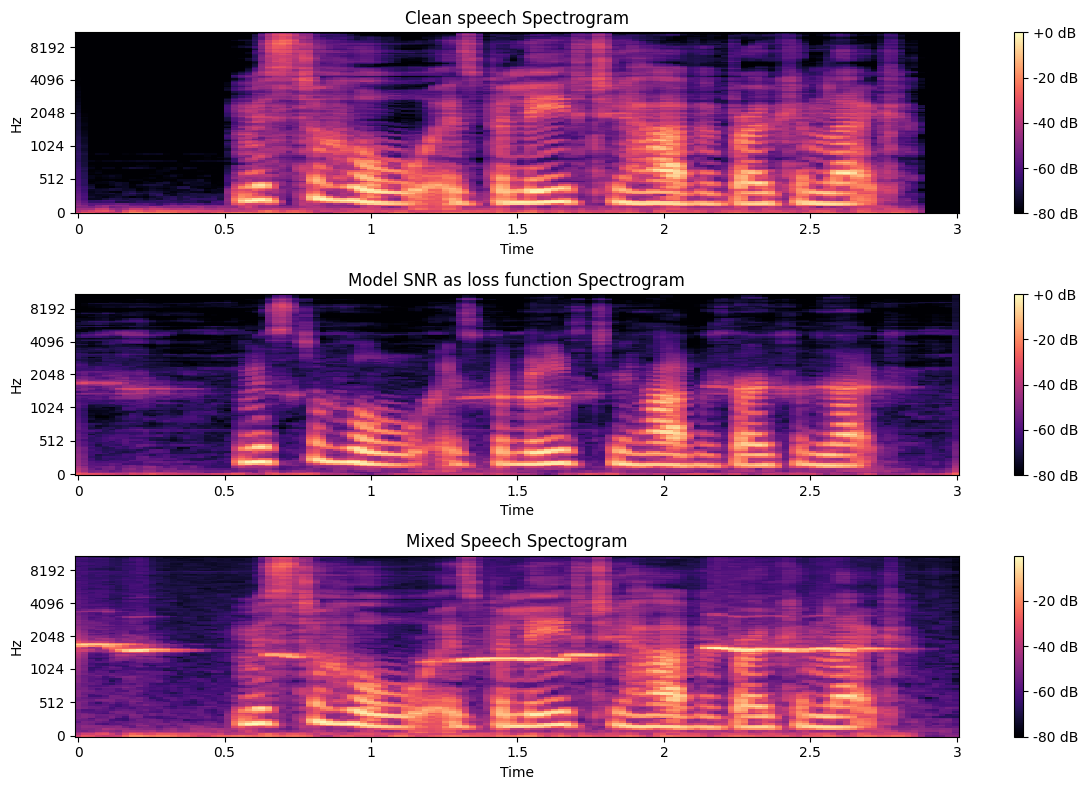

In [37]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
# Load the audio file


# # Load the input audio file
# audio_path_clean = '/content/drive/MyDrive/audio_pure_speech.wav' #clean speech
# input_audio, input_sr_snr = librosa.load(audio_path_clean)
# input_spectrogram = librosa.feature.melspectrogram(y=input_audio, sr=input_sr)
# input_spectrogram_db_snr = librosa.power_to_db(input_spectrogram, ref=np.max)

# # Load the output audio file
# audio_path_model = '/content/drive/MyDrive/audio_model.wav'
# output_audio, output_snr_sr = librosa.load(audio_path_model)
# output_spectrogram = librosa.feature.melspectrogram(y=output_audio, sr=output_sr)
# output_spectrogram_db_snr = librosa.power_to_db(output_spectrogram, ref=np.max)

# # Load the input audio file
# audio_path_speech_noise = "/content/drive/MyDrive/audio_mixed_speech.wav" #sound with noise
# input_audio, input_sr = librosa.load(audio_path_speech_noise)
# input_spectrogram = librosa.feature.melspectrogram(y=input_audio, sr=input_sr)
# input_spectrogram_db_mse = librosa.power_to_db(input_spectrogram, ref=np.max)

# Load the input audio file
input_audio_path = '/content/drive/MyDrive/audio_pure_speech.wav'
input_audio_snr, input_sr_snr = librosa.load(input_audio_path)
input_spectrogram_snr = librosa.feature.melspectrogram(y=input_audio_snr, sr=input_sr_snr)
input_spectrogram_db_snr = librosa.power_to_db(input_spectrogram_snr, ref=np.max)

# Load the output audio file for 1/SNR
output_audio_path_snr = '/content/drive/MyDrive/audio_model.wav'
output_audio_snr, output_sr_snr = librosa.load(output_audio_path_snr)
output_spectrogram_snr = librosa.feature.melspectrogram(y=output_audio_snr, sr=output_sr_snr)
output_spectrogram_db_snr = librosa.power_to_db(output_spectrogram_snr, ref=np.max)

# Load the output audio file for MSE
output_audio_path_mse = '/content/drive/MyDrive/audio_mixed_speech.wav'
output_audio_mse, output_sr_mse = librosa.load(output_audio_path_mse)
output_spectrogram_mse = librosa.feature.melspectrogram(y=output_audio_mse, sr=output_sr_mse)
output_spectrogram_db_mse = librosa.power_to_db(output_spectrogram_mse, ref=np.max)



# Create a 2x2 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))


# Plot the input spectrogram with colorbar
librosa.display.specshow(input_spectrogram_db_snr, sr=input_sr_snr, x_axis='time', y_axis='mel', ax=axs[0]) #CLean SPeech
axs[0].set_title('Clean speech Spectrogram')
fig.colorbar(axs[0].collections[0], ax=axs[0], format='%+2.0f dB')  # Add colorbar


# Plot the output spectrogram for 1/SNR with colorbar
librosa.display.specshow(output_spectrogram_db_snr, sr=output_sr_snr, x_axis='time', y_axis='mel', ax=axs[1]) #Audio Model
axs[1].set_title('Model SNR as loss function Spectrogram')
fig.colorbar(axs[1].collections[0], ax=axs[1], format='%+2.0f dB')  # Add colorbar

# Plot the output spectrogram for 1/SNR with colorbar
librosa.display.specshow(output_spectrogram_db_mse, sr=output_sr_mse, x_axis='time', y_axis='mel', ax=axs[2]) #Mixed speech
axs[2].set_title('Mixed Speech Spectogram')
fig.colorbar(axs[2].collections[0], ax=axs[2], format='%+2.0f dB')  # Add colorbar

# Add more plots if needed
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/audio_image.png')
plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 8))




# # Plot the input spectrogram with colorbar
# librosa.display.specshow(input_spectrogram_db_snr, sr=input_sr, x_axis='time', y_axis='mel', ax=axs[0, 0])
# axs[0, 0].set_title('Clean speech Spectrogram')
# fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0], format='%+2.0f dB')  # Add colorbar


# # Plot the output spectrogram with colorbar
# librosa.display.specshow(output_spectrogram_db_snr, sr=output_sr, x_axis='time', y_axis='mel', ax=axs[0, 1])
# axs[0, 1].set_title('Model output Spectrogram with model audio')
# fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1], format='%+2.0f dB')  # Add colorbar

# # Plot the input spectrogram with colorbar
# librosa.display.specshow(input_spectrogram_db_mse, sr=input_sr, x_axis='time', y_axis='mel', ax=axs[1, 0])
# axs[1, 0].set_title('Noisy speech Spectrogram with mixed speech')
# fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0], format='%+2.0f dB')  # Add colorbar
<<<<<<<<<
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/audio_image.png')
# plt.show()
# # torchaudio.save('/content/drive/MyDrive/audio_image.pdf', y_orig, sample_rate)